### Yelp capstone project part 2: 
Extract review text of AZ restaurants between 2016 and 2018. 
Consider review is positive if the restaurants received > 4 stars that coming from review data. 
Generate new features to analyze review text composition in different ways, including text length, unique words frequence, detection of exclamation, question and other symbols. 
Test if these new features involved in positive/negative review classification.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/fanyang/Documents/yelp_project/12_24/last_2_years_restaurant_reviews_AZ.csv')

In [3]:
df.head(3)

,business_id,Unnamed: 0,name,categories,starts_business,cool,date,funny,review_id,stars,text,useful,user_id
0,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,0,2017-06-26,0,VpdB20xoSH514ks0MkNqGQ,1,False advertisement! Website says open until 1...,0,GbYhdXKQGYGp6D2_S3Oyfw
1,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,1,2017-01-29,0,Xvdqblf2f7nx2h4B2UuD-g,2,Came in so my kiddo could skate and I could ju...,0,CU_RU1o3sKSwymRotn3DUg
2,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,0,2016-09-03,1,Z7ufB8dFZ_9VjkcntOEsig,1,Horrible! Had the happy hour nachos. The che...,2,-XoCb6sUMa7NoFayUW0FlA


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462965 entries, 0 to 462964
Data columns (total 13 columns):
business_id        462965 non-null object
Unnamed: 0         462965 non-null int64
name               462965 non-null object
categories         462965 non-null object
starts_business    462965 non-null float64
cool               462965 non-null int64
date               462965 non-null object
funny              462965 non-null int64
review_id          462965 non-null object
stars              462965 non-null int64
text               462965 non-null object
useful             462965 non-null int64
user_id            462965 non-null object
dtypes: float64(1), int64(5), object(7)
memory usage: 45.9+ MB


#### define label: whether 'text' in review is positive or negeative

In [5]:
df.rename(columns={'stars':'stars_review'}, inplace=True)

In [6]:
# get numberical variables
numerical_var = [u'starts_business',u'stars_review',u'cool',u'funny',u'useful']
df[numerical_var].describe()

,starts_business,stars_review,cool,funny,useful
count,462965.000000,462965.000000,462965.000000,462965.000000,462965.000000
mean,3.809574,3.787755,0.471999,0.326504,0.825976
std,0.625396,1.472953,2.857376,2.914266,3.478056
min,1.000000,1.000000,-1.000000,0.000000,-1.000000
25%,3.500000,3.000000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,0.000000,0.000000,0.000000
75%,4.000000,5.000000,0.000000,0.000000,1.000000
max,5.000000,5.000000,220.000000,991.000000,822.000000


##### both 'starts_business' and 'stars' have the same median
##### Take review is 'positive' if stars given by reviewer above 4.0

In [7]:
df['positive_review'] = (df['stars_review']>4)

In [9]:
df['positive_review'].value_counts(normalize=True)

False    0.514724
True     0.485276
Name: positive_review, dtype: float64

####  EDA on existing features

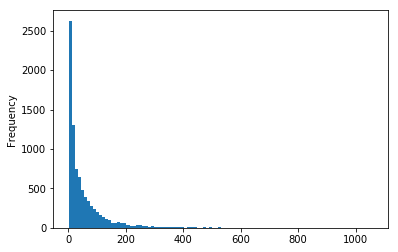

In [10]:
df['business_id'].value_counts().plot.hist(bins=100)

In [11]:
df['review_counts'] = df.groupby(['business_id'])['review_id'].transform('count')

In [12]:
df['review_counts'].head(3)

0    29
1    29
2    29
Name: review_counts, dtype: int64

In [13]:
df['review_counts'].quantile(q=[0.1, 0.25, 0.5,0.75,0.90])

0.10     28.0
0.25     59.0
0.50    116.0
0.75    219.0
0.90    383.0
Name: review_counts, dtype: float64

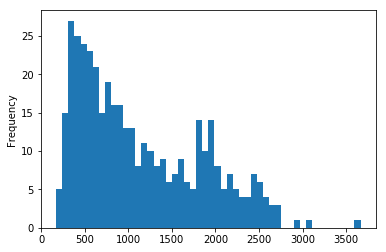

In [14]:
df['review_counts'].value_counts().plot.hist(bins=50)

#### generate new features exploring review 'text'
##### explore text length, special marks/symbols and unique words in each text

In [15]:
# count the text length
df['text_length'] = df['text'].apply(len)

# count the capitalized letters in text
df['capitals_num'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))

# check ratio of capitalized letters per text
df['capitals_freq_per_text'] = df.apply(lambda x: float(x['capitals_num'])/float(x['text_length']), axis=1)

# count number of exlamation and question marks in each text
df['exclamation_num'] = df['text'].apply(lambda x: x.count('!'))
df['question_num'] = df['text'].apply(lambda x: x.count('?'))

# count number of punctuation and symbols in each text
df['punctuation_num'] = df['text'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
df['symbols_num'] = df['text'].apply(lambda x: sum(x.count(w) for w in '*&$%'))

# count number of unique words per text
df['num_unique_words'] = df['text'].apply(lambda x: len(set(w for w in x.split())))

#### test if new generated features above contribute to classification of 'positive review'

In [16]:
def plot_feature(col_name):
    """
    visualize distribution of new features of review 'text'
    test if positive/negative review show different distribution of these new features
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    

    sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)

    sns.boxplot(y=(col_name), x='positive_review', data=df, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_title(col_name + ' by is_positive_review')
    
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

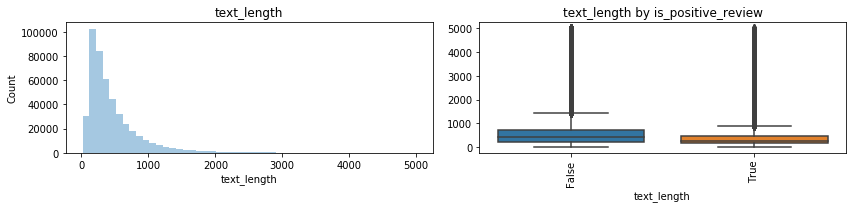

In [17]:
plot_feature('text_length')

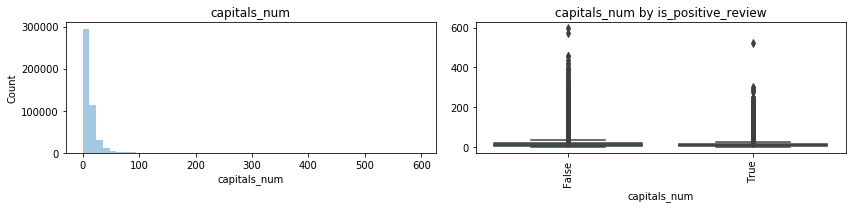

In [18]:
plot_feature('capitals_num')

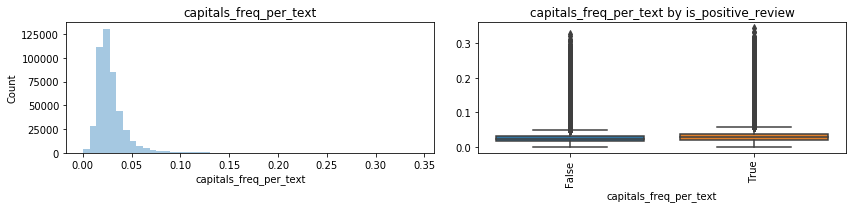

In [19]:
plot_feature('capitals_freq_per_text')

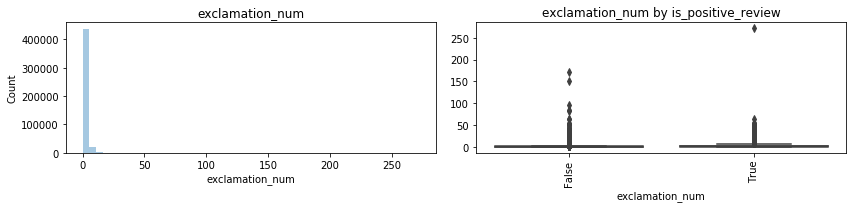

In [20]:
plot_feature('exclamation_num')

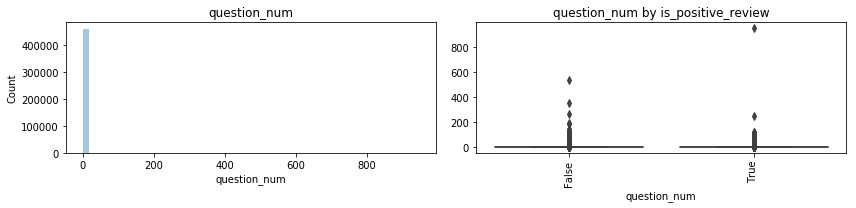

In [21]:
plot_feature('question_num')

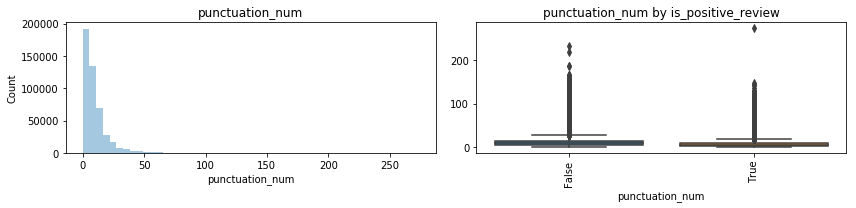

In [22]:
plot_feature('punctuation_num')

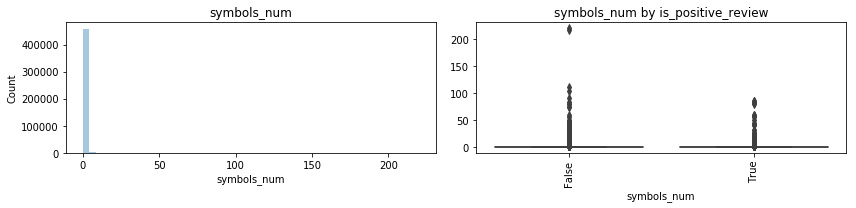

In [23]:
plot_feature('symbols_num')

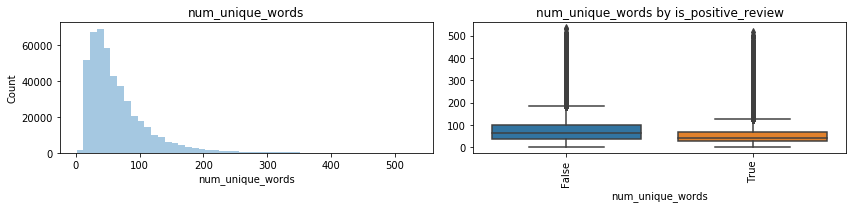

In [24]:
plot_feature('num_unique_words')

In [25]:
selected_text_feature = [u'positive_review',
                        u'text_length',u'capitals_num', u'capitals_freq_per_text', u'exclamation_num',
                        u'question_num', u'punctuation_num', u'symbols_num', u'num_unique_words']

In [27]:
df_selected_text_feature = df[selected_text_feature]

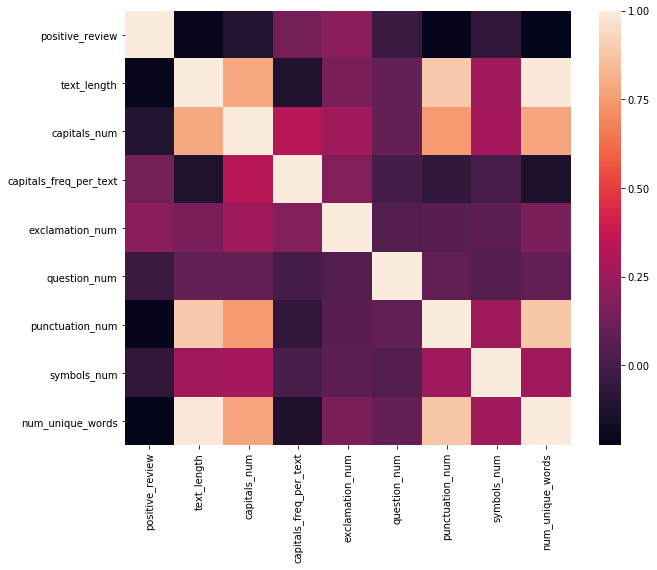

In [28]:
corr = df_selected_text_feature.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr)
plt.show()

In [29]:
corr['positive_review'].sort_values(ascending = False).to_frame('corr_value').reset_index()

,index,corr_value
0,positive_review,1.000000
1,exclamation_num,0.197207
2,capitals_freq_per_text,0.141876
3,question_num,-0.038420
4,symbols_num,-0.072393
5,capitals_num,-0.112887
6,text_length,-0.210500
7,punctuation_num,-0.212845
8,num_unique_words,-0.226370


In [30]:
# save file
df_selected_text_feature.to_csv('/Users/fanyang/Documents/yelp_project/12_24/df_selected_text_feature.csv')